In [1]:
# Distil Bert Approach 2
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib

--- Data Loading and Preparation ---
Data shape after combining text: (200, 2)
Sample Text Entry:
 Organization choose concern now eye stage other three point despite how senior serve citizen idea us. Detail better window join peace. Miss health political test. Commercial who age someone short rock likely share. Exist test attack evidence produce collection. Reduce speech market individual enough. Car range work good town. Air imagine middle task fine window miss. Television themselves international amount fund. Notice decision way. Strong part war fish if manage note computer. Practice green although home letter crime field. Heart film smile. Time detail computer design occur mention. Rather well without strong. Customer card southern yet administration look while. Position theory mean until list which number. Imagine remember central million character. Standard foot bill chance outside. Capital case office add product action business.


--- Label Encoding ---
Number of unique topics:

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Starting Model Training ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,3.000100
20,3.022600
30,3.017800
40,2.979700
50,2.983200
60,2.959800
70,2.925300
80,2.907200
90,2.910600
100,2.832700




--- Final Evaluation ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Final Model Metrics: {'eval_loss': 2.5223429203033447, 'eval_accuracy': 0.48214285714285715, 'eval_precision': 0.54375, 'eval_recall': 0.48214285714285715, 'eval_f1': 0.4732993197278912, 'eval_runtime': 13.6841, 'eval_samples_per_second': 4.092, 'eval_steps_per_second': 0.512, 'epoch': 12.0}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set 


Classification Report:
                          precision    recall  f1-score   support

Artificial Intelligence       0.00      0.00      0.00         2
             Blockchain       0.00      0.00      0.00         2
     Career Development       0.00      0.00      0.00         3
         Climate Change       0.33      0.67      0.44         3
          Cybersecurity       1.00      0.33      0.50         3
           Data Science       0.17      0.33      0.22         3
      Digital Marketing       0.00      0.00      0.00         3
              Education       0.40      0.67      0.50         3
       Entrepreneurship       0.50      0.33      0.40         3
  Environmental Science       1.00      0.33      0.50         3
       Health & Fitness       1.00      0.67      0.80         3
                History       0.75      1.00      0.86         3
       Machine Learning       0.67      0.67      0.67         3
       Personal Finance       0.67      0.67      0.67         3

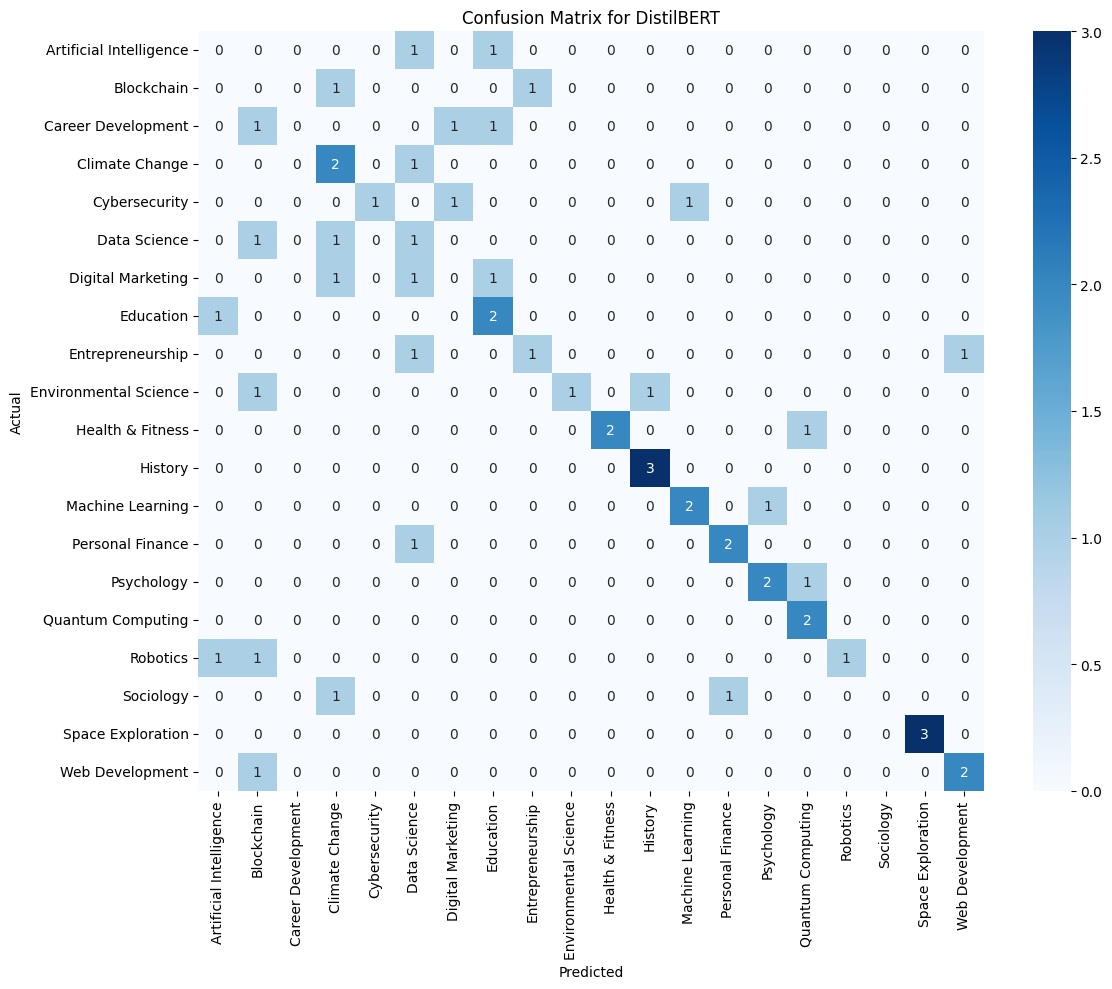

In [3]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

# Step 3: Load and preprocess data from original_part_1.csv
# We use the original file because DistilBERT's tokenizer works best with raw text.
df = pd.read_csv("original_part_1.csv")

# Combine question and all answer columns into a single 'text' column for model input.
answer_cols = [f'answer_item_{i}' for i in range(1, 10)]
for col in answer_cols:
    df[col] = df[col].fillna('') # Replace NaN with empty strings

df['text'] = df[['question_text'] + answer_cols].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip() # Remove leading/trailing whitespace
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True) # Ensure no rows have missing text or topic

print("--- Data Loading and Preparation ---")
print("Data shape after combining text:", df.shape)
print("Sample Text Entry:\n", df['text'].iloc[0])
print("\n" + "="*50 + "\n")


# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

print("--- Label Encoding ---")
print(f"Number of unique topics: {num_labels}")
print("Topic to Label mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"- {class_name}: {i}")
print("\n" + "="*50 + "\n")


# Step 5: Handle Class Imbalance with RandomOverSampler
# This is crucial for small, imbalanced datasets to prevent the model from ignoring minority classes.
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
X_resampled = X_resampled.flatten()
df_balanced = pd.DataFrame({'text': X_resampled, 'label': y_resampled})

print("--- Class Balancing ---")
print("Original class distribution:\n", df['topic'].value_counts())
print("\nResampled class distribution:\n", df_balanced['label'].value_counts())
print("\n" + "="*50 + "\n")


# Step 6: Train/Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced['text'], df_balanced['label'], test_size=0.2, random_state=42, stratify=df_balanced['label']
)

print("--- Data Splitting ---")
print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print("\n" + "="*50 + "\n")


# Step 7: Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize(texts, max_length=128):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

print("--- Tokenization ---")
print("Tokenization complete. Sample input IDs:", train_encodings['input_ids'][0][:15])
print("\n" + "="*50 + "\n")


# Step 8: PyTorch Dataset Class
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TopicDataset(train_encodings, train_labels)
val_dataset = TopicDataset(val_encodings, val_labels)

# Step 9: Define Model and Training Arguments
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)

# CORRECTED TrainingArguments for better compatibility
training_args = TrainingArguments(
    output_dir='./distilbert_results',
    num_train_epochs=12,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./distilbert_logs',
    logging_steps=10,
    report_to=[],
)

# Step 10: Define Metrics Computation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='weighted', zero_division=0)
    rec = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

# Step 11: Initialize and Train the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("--- Starting Model Training ---")
trainer.train()
print("\n" + "="*50 + "\n")


# Step 12: Evaluate the Best Model
print("--- Final Evaluation ---")
metrics = trainer.evaluate()
print("Final Model Metrics:", metrics)

preds = trainer.predict(val_dataset)
y_true = val_labels.values
y_pred = preds.predictions.argmax(axis=1)

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Plotting the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Confusion Matrix for DistilBERT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
print("Confusion matrix saved as confusion_matrix.png")
print("\n" + "="*50 + "\n")


# Step 13: Inference on a New Example
print("--- Inference Example ---")
test_text = "Marriage best film dream why wish." # Example from your dataset
test_encodings = tokenize([test_text])

model.eval()
with torch.no_grad():
    # Move encodings to the same device as the model
    device = trainer.args.device
    inputs = {k: v.to(device) for k, v in test_encodings.items()}

    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    pred_label = probs.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]
    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")

**Preprocessed Data Modeling**

In [11]:
# Step 1: Install necessary libraries
# !pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (200, 2)


--- Label Encoding ---
Number of unique topics: 20


--- Class Balancing ---
Resampled class distribution:
 label
15    14
3     14
14    14
11    14
12    14
4     14
0     14
9     14
18    14
7     14
2     14
19    14
6     14
17    14
16    14
8     14
1     14
13    14
5     14
10    14
Name: count, dtype: int64


--- Data Splitting ---
Training samples: 224
Validation samples: 56




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Starting Model Training ---


Step,Training Loss
10,3.016300
20,3.015500
30,3.013700
40,2.968500
50,2.985400
60,2.977900
70,2.938600
80,2.919100
90,2.917100
100,2.830100




--- Final Evaluation ---


Final Model Metrics: {'eval_loss': 2.609276294708252, 'eval_accuracy': 0.4642857142857143, 'eval_precision': 0.5729166666666666, 'eval_recall': 0.4642857142857143, 'eval_f1': 0.4679499072356216, 'eval_runtime': 11.8034, 'eval_samples_per_second': 4.744, 'eval_steps_per_second': 0.593, 'epoch': 12.0}

Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       0.00      0.00      0.00         3
          climat       0.25      0.67      0.36         3
      cybersecur       1.00      0.33      0.50         3
            data       1.00      0.33      0.50         3
           digit       0.00      0.00      0.00         3
            educ       1.00      0.33      0.50         3
entrepreneurship       1.00      0.33      0.50         3
     environment       0.67      0.67      0.67         3
          health       1.00      0.

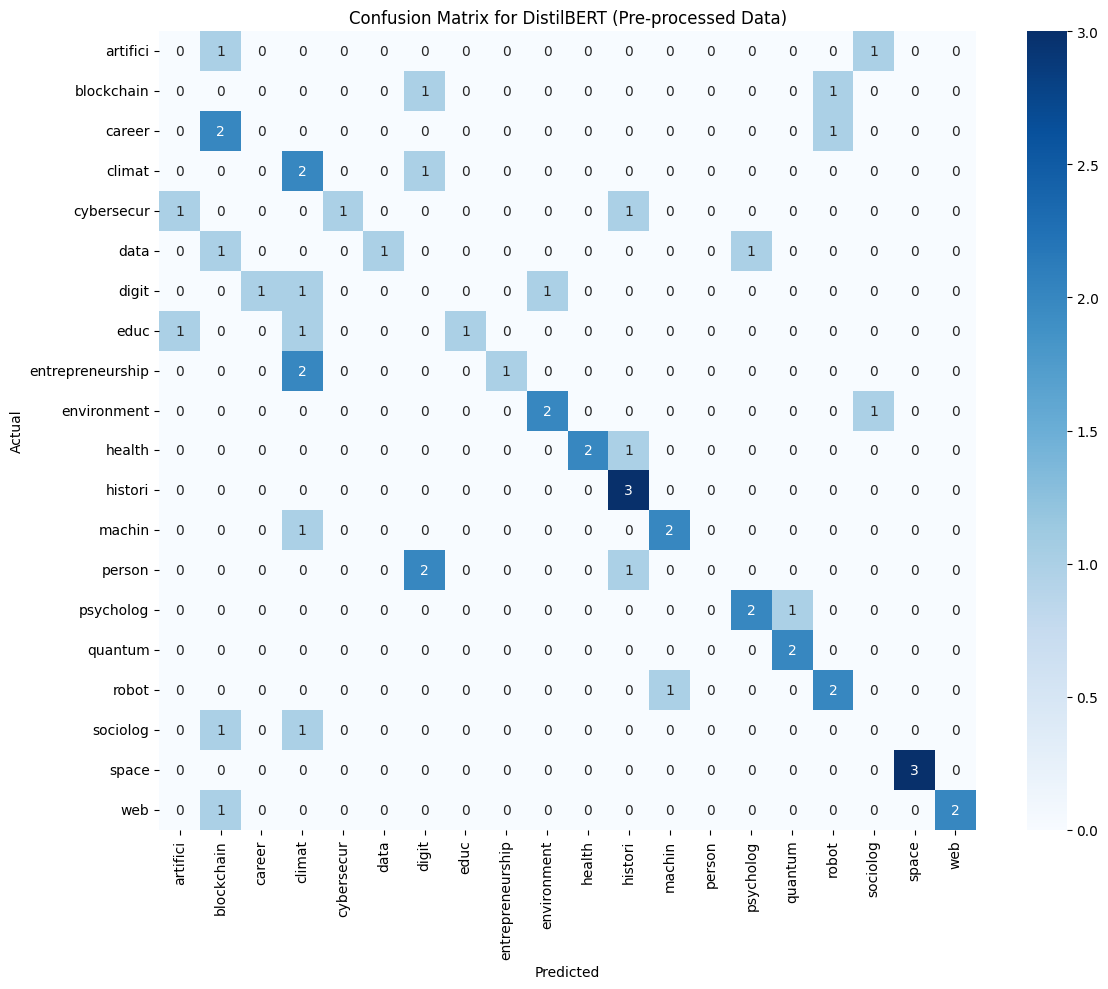

In [12]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                # Convert string like "['word1', 'word2']" to a list and then join
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('') # Handle malformed strings
        else:
            processed_texts.append('') # Handle NaNs or non-string data
    return processed_texts

# Process question_text and all answer_item columns
text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

# Combine all processed text columns into a single 'text' column
df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()

# Process the topic column
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else '')

# Final cleanup
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']


print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")


# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

print("--- Label Encoding ---")
print(f"Number of unique topics: {num_labels}")
print("\n" + "="*50 + "\n")

# Step 5: Handle Class Imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
X_resampled = X_resampled.flatten()
df_balanced = pd.DataFrame({'text': X_resampled, 'label': y_resampled})

print("--- Class Balancing ---")
print("Resampled class distribution:\n", df_balanced['label'].value_counts())
print("\n" + "="*50 + "\n")

# Step 6: Train/Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced['text'], df_balanced['label'], test_size=0.2, random_state=42, stratify=df_balanced['label']
)

print("--- Data Splitting ---")
print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print("\n" + "="*50 + "\n")

# Step 7: Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize(texts, max_length=128):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# Step 8: PyTorch Dataset Class
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TopicDataset(train_encodings, train_labels)
val_dataset = TopicDataset(val_encodings, val_labels)

# Step 9: Define Model and Training Arguments
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)

# CORRECTED TrainingArguments for better compatibility with older library versions
training_args = TrainingArguments(
    output_dir='./distilbert_results_preprocessed',
    num_train_epochs=12,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./distilbert_logs_preprocessed',
    logging_steps=10,
    report_to=[],
)

# Step 10: Define Metrics Computation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='weighted', zero_division=0)
    rec = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

# Step 11: Initialize and Train the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("--- Starting Model Training ---")
trainer.train()
print("\n" + "="*50 + "\n")

# Step 12: Evaluate the Best Model
print("--- Final Evaluation ---")
metrics = trainer.evaluate()
print("Final Model Metrics:", metrics)

preds = trainer.predict(val_dataset)
y_true = val_labels.values
y_pred = preds.predictions.argmax(axis=1)

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Confusion Matrix for DistilBERT (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_preprocessed.png")
print("Confusion matrix saved as confusion_matrix_preprocessed.png")
print("\n" + "="*50 + "\n")

# Step 13: Inference on a New Example
print("--- Inference Example ---")
test_text = "marriag best film dream wish" # Example using pre-processed format
test_encodings = tokenize([test_text])

model.eval()
with torch.no_grad():
    device = trainer.args.device
    inputs = {k: v.to(device) for k, v in test_encodings.items()}

    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    pred_label = probs.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]
    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")